In [2]:
pip install nltk

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.5 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 284 kB 64.3 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 27.0 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [118]:
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [119]:
data = []
for line in open('data/Luxury_Beauty_5.json', 'r'):  
    data.append(json.loads(line))
df = pd.DataFrame(data)

Предобработка текста

In [120]:
# nltk.download('stopwords')
# nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['cleaned_text'] = df['reviewText'].apply(clean_text)

Векторизация текста

In [121]:
tfidf = TfidfVectorizer(
    max_features=1000, # 1000 самых важных слов
    min_df=3,          # Игнорировать редкие слова
    max_df=0.9,        # Игнорировать слишком частые слова
)

x_tfidf = tfidf.fit_transform(df['cleaned_text']).toarray()
# создание таблицы, где:
# каждая строка = один отзыв
# каждый столбец = одно из 1000 отобранных слов
# в ячейках = "вес" слова: чем чаще слово в отзыве и реже в других — тем выше

x = x_tfidf

Метод K-средних + выбор оптимального K с использованием метода силуэтов

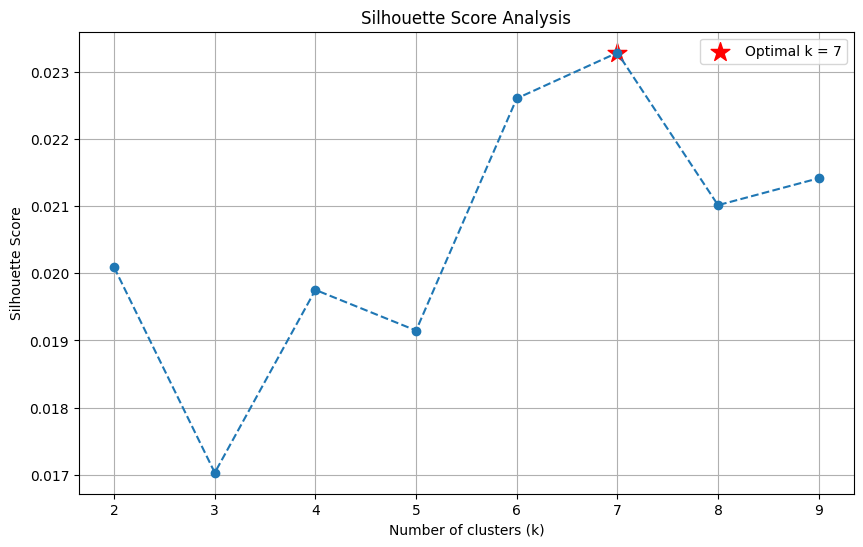

In [132]:
# Алгоритм случайно выбирает K точек (центроидов) — «центры» будущих кластеров
# Каждую точку данных относят к ближайшему центроиду
# После распределения всех точек, центроиды перемещаются в среднюю точку своего кластера
# Процесс повторяется, пока: центроиды перестанут смещаться/кластеры стабилизируются/достигнуто максимальное число итераций
def optimize_kmeans(x):
    silhouette_scores = []
    k_values = range(2, 10)
    
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(x)
        silhouette_scores.append(silhouette_score(x, labels)) # считает силуэтный коэффициент (насколько четко разделены кластеры)

    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o', linestyle='--')
    
    optimal_k = np.argmax(silhouette_scores) + 2  # +2 т.к. начали с k=2
    plt.scatter(optimal_k, 
                silhouette_scores[optimal_k-2], 
                color='red', 
                s=200, 
                marker='*',
                label=f'Optimal k = {optimal_k}')
    
    plt.title('Silhouette Score Analysis')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_values)
    plt.grid(True)
    plt.legend()
    plt.show()

    return KMeans(n_clusters=optimal_k, random_state=42), optimal_k

kmeans_model, optimal_k = optimize_kmeans(x)
kmeans_labels = kmeans_model.fit_predict(x)

Визуализация K-средних

[]

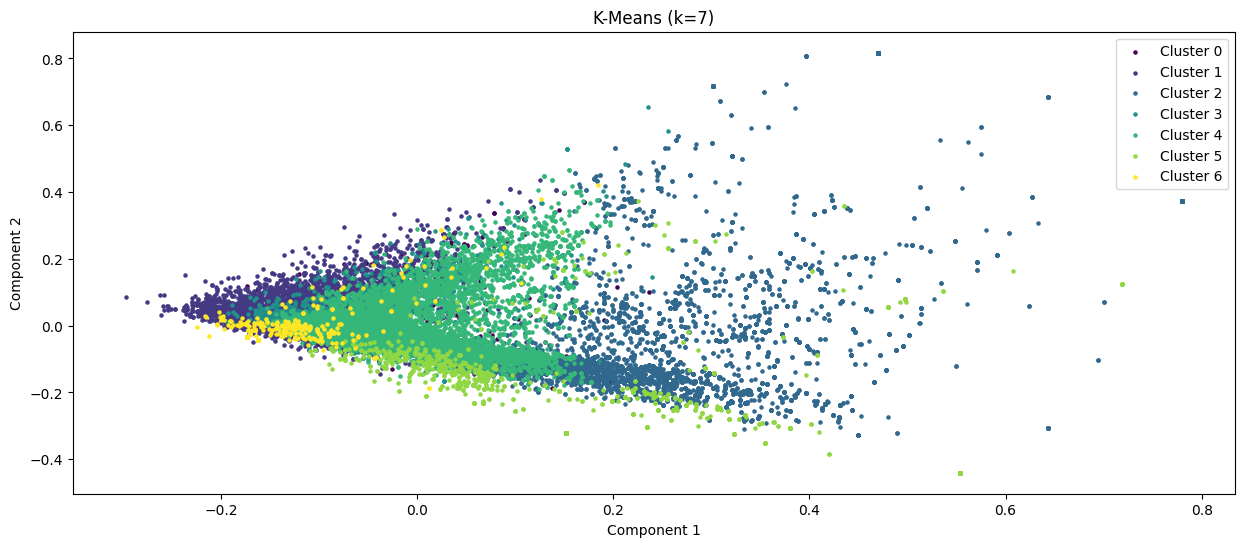

In [130]:
x_proj = PCA(n_components=2).fit_transform(x) # уменьшаем размерность для 2D-отображения

unique_labels = np.unique(kmeans_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(15, 6))
for label, color in zip(unique_labels, colors):
    if label == -1:
        color = [0.5, 0.5, 0.5, 1]  # Серый для шума
    mask = (kmeans_labels == label)
    plt.scatter(x_proj[mask, 0], x_proj[mask, 1], c=[color], s=5, label=f'Cluster {label}')
plt.title(f'K-Means (k={optimal_k})')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.plot()

Оценка K-средних

In [124]:
def print_top_words_per_cluster(tfidf_vectorizer, df, labels, n_words=10):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    clusters = np.unique(labels)
    
    top_words = {}
    
    for cluster in clusters:
        if cluster == -1:
            continue  # Пропускаем шумовые точки
        
        cluster_mask = (labels == cluster)

        cluster_texts = df[cluster_mask]['cleaned_text']
        tfidf_scores = x[cluster_mask].sum(axis=0)
        top_words = [feature_names[idx] for idx in np.argsort(tfidf_scores)[-5:][::-1]]
        print(f"Кластер {cluster}: {', '.join(top_words)}")

print("\nТоп-слова по кластерам K-Means:")
print_top_words_per_cluster(tfidf, df, kmeans_labels)


Топ-слова по кластерам K-Means:
Кластер 0: eye, good, product, cream, skin
Кластер 1: skin, product, face, feel, use
Кластер 2: color, love, polish, nail, coat
Кластер 3: hair, product, shampoo, use, conditioner
Кластер 4: product, like, scent, love, smell
Кластер 5: great, color, product, love, work
Кластер 6: soap, shave, shaving, proraso, lather


Метод DBSCAN

In [126]:
from sklearn.decomposition import TruncatedSVD

# снижение размерности для DBSCAN до 10 измерений
svd = TruncatedSVD(n_components=100)
x_umap = UMAP(n_components=10, metric='cosine').fit_transform(svd.fit_transform(x_tfidf))
x_scaled = StandardScaler().fit_transform(x_umap)

# Алгоритм сканирует все точки данных и для каждой точки проверяет:
# есть ли в радиусе eps не менее min_samples точек?
# если да — формирует кластер
# если нет — помечает точку как шум (метка -1)

optimal_eps = 0.5 # максимальное расстояние между двумя точками, чтобы считать их соседями
dbscan_model = DBSCAN(eps=optimal_eps, min_samples=500, metric='euclidean') 
# минимальное число точек для формирования кластера = 500 (выбрано пробами - чтобы было адекватное кол-во кластеров)
# метрика расстояния (евклидово расстояние)
dbscan_labels = dbscan_model.fit_predict(x_scaled)

/Users/karpova.eo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Визуализация DBSCAN

[]

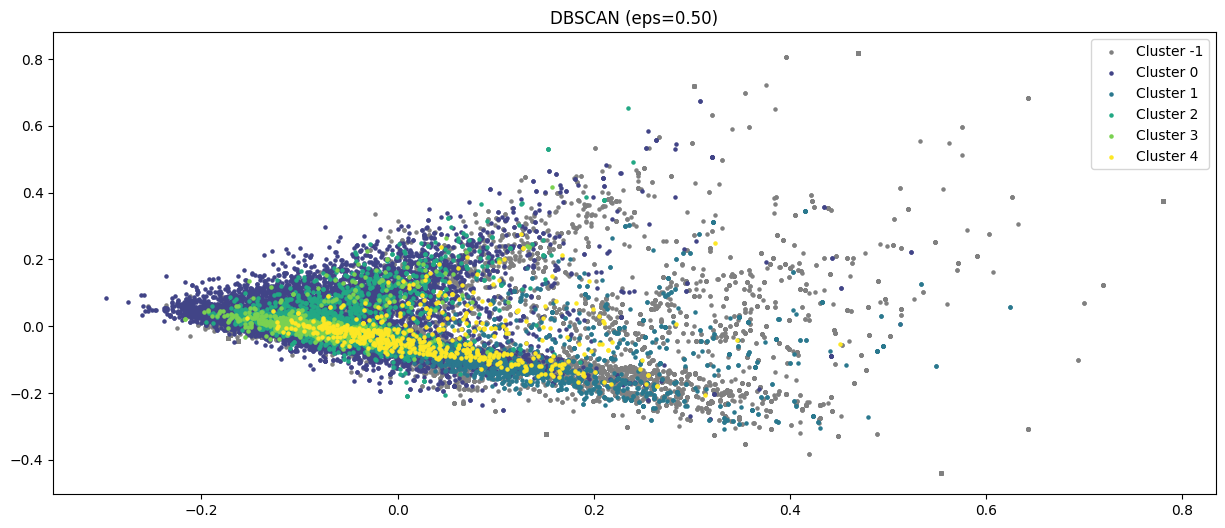

In [127]:
plt.figure(figsize=(15, 6))
unique_labels = np.unique(dbscan_labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    if label == -1:
        color = [0.5, 0.5, 0.5, 1]  # серый для шума
    mask = (dbscan_labels == label)
    plt.scatter(x_proj[mask, 0], x_proj[mask, 1], c=[color], s=5, label=f'Cluster {label}')

plt.title(f'DBSCAN (eps={optimal_eps:.2f})')
plt.legend()
plt.plot()

Оценка DBSCAN

In [128]:
print("\nТоп-слова по кластерам DBSCAN:")
print_top_words_per_cluster(tfidf, df, dbscan_labels)


Топ-слова по кластерам DBSCAN:
Кластер 0: skin, product, like, use, face
Кластер 1: nail, polish, coat, color, love
Кластер 2: hair, shampoo, product, conditioner, use
Кластер 3: sunscreen, skin, sun, spf, face
Кластер 4: lip, lipstick, color, gloss, balm
